# NYC Transportation Analysis

## 1 Introduction

This is an exploratory data analysis for Airbnb hosts information from 2016 to 2018. The results shown in this notebook will be used for building TripElf, an interactive map application. We want to discover the number of bus stops and subway entrances within New York City neighbourhoods.

### 1.1 Load Libraries

In [2]:
# settings
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")
from shapely.geometry import Point, Polygon
import seaborn as sns

### 1.2 Load Dataset

In [5]:
busstop = pd.read_csv("busstop.csv")
busstop.head()

,CounDist,BoroCD,AssemDist,the_geom,CongDist,StSenDist,SHELTER_ID,LOCATION,AT_BETWEEN,LONGITUDE,LATITUDE,AssetID,BoroCode,BoroName,Street,SegmentID,PhysicalID,NODEID
0,34,301,53,POINT (-73.94783099999995 40.70681200000007),7,18,BR0003,MONTROSE AV,LORIMER ST,-73.947831,40.706812,1,3,Brooklyn,MONTROSE AVENUE,31244.0,91546,0
1,34,301,50,POINT (-73.94516199999998 40.71909700000003),12,18,BR0014,GRAHAM AV,HERBERT ST,-73.945162,40.719097,2,3,Brooklyn,GRAHAM AVENUE,35598.0,45754,0
2,34,301,53,POINT (-73.94578299999995 40.702976000000035),7,18,BR0026,BROADWAY,LEONARD ST,-73.945783,40.702976,3,3,Brooklyn,BROADWAY,31350.0,43972,19920
3,34,301,50,POINT (-73.94083599999993 40.72019500000005),12,18,BR0028,KINGSLAND AV,HERBERT ST,-73.940836,40.720195,4,3,Brooklyn,KINGSLAND AVENUE,65844.0,48893,40551
4,35,302,50,POINT (-73.96979499999998 40.69344000000007),8,25,BR0040,VANDERBILT AV,MYRTLE AV,-73.969795,40.693440,5,3,Brooklyn,VANDERBILT AVENUE,30196.0,60512,0


In [4]:
subway = pd.read_csv("subway.csv")
subway.head()

,OBJECTID,URL,NAME,the_geom,LINE
0,1734,http://web.mta.info/nyct/service/,Birchall Ave & Sagamore St at NW corner,POINT (-73.86835600032798 40.84916900104506),2-5
1,1735,http://web.mta.info/nyct/service/,Birchall Ave & Sagamore St at NE corner,POINT (-73.86821300022677 40.84912800131844),2-5
2,1736,http://web.mta.info/nyct/service/,Morris Park Ave & 180th St at NW corner,POINT (-73.87349900050798 40.84122300105249),2-5
3,1737,http://web.mta.info/nyct/service/,Morris Park Ave & 180th St at NW corner,POINT (-73.8728919997833 40.84145300067447),2-5
4,1738,http://web.mta.info/nyct/service/,Boston Rd & 178th St at SW corner,POINT (-73.87962300013866 40.84081500075867),2-5


### 1.3 Dataset structure and content

In [10]:
# bus stop dataset
print("Shape of the dataset: ", busstop.shape)

Shape of the dataset:  (3428, 18)


CounDist        int64
BoroCD          int64
AssemDist       int64
the_geom       object
CongDist        int64
StSenDist       int64
SHELTER_ID     object
LOCATION       object
AT_BETWEEN     object
LONGITUDE     float64
LATITUDE      float64
AssetID         int64
BoroCode        int64
BoroName       object
Street         object
SegmentID     float64
PhysicalID      int64
NODEID          int64
dtype: object

In [11]:
busstop.columns

Index(['CounDist', 'BoroCD', 'AssemDist', 'the_geom', 'CongDist', 'StSenDist', 'SHELTER_ID', 'LOCATION', 'AT_BETWEEN', 'LONGITUDE', 'LATITUDE', 'AssetID', 'BoroCode', 'BoroName', 'Street', 'SegmentID', 'PhysicalID', 'NODEID'], dtype='object')

In [12]:
busstop.dtypes

CounDist        int64
BoroCD          int64
AssemDist       int64
the_geom       object
CongDist        int64
StSenDist       int64
SHELTER_ID     object
LOCATION       object
AT_BETWEEN     object
LONGITUDE     float64
LATITUDE      float64
AssetID         int64
BoroCode        int64
BoroName       object
Street         object
SegmentID     float64
PhysicalID      int64
NODEID          int64
dtype: object

In [13]:
# subway
print("Shape of the dataset: ", subway.shape)

Shape of the dataset:  (3428, 18)


In [14]:
subway.columns

Index(['OBJECTID', 'URL', 'NAME', 'the_geom', 'LINE'], dtype='object')

In [15]:
subway.dtypes

OBJECTID     int64
URL         object
NAME        object
the_geom    object
LINE        object
dtype: object

### 1.4 Missing Values

In [17]:
# bus stop
print("Number of rows of the dataset: ", len(busstop))
busstop.isnull().sum()

Number of rows of the dataset:  3428


CounDist      0
BoroCD        0
AssemDist     0
the_geom      0
CongDist      0
StSenDist     0
SHELTER_ID    0
LOCATION      0
AT_BETWEEN    0
LONGITUDE     0
LATITUDE      0
AssetID       0
BoroCode      0
BoroName      0
Street        4
SegmentID     4
PhysicalID    0
NODEID        0
dtype: int64

In [18]:
# subway
print("Number of rows of the dataset: ", len(subway))
subway.isnull().sum()

Number of rows of the dataset:  1928


OBJECTID     0
URL          0
NAME        29
the_geom     0
LINE         0
dtype: int64

## 2 Feature Aggregration

In [22]:
# assign neighbourhood to point for busstop

def append_neighborhood(df, geo_df):
    # Create a list of Point objects
    point_list = []
    for idx, biz in df.iterrows():
        point_list.append(Point(biz["LONGITUDE"], biz["LATITUDE"]))
    
    # Create a list of Polygon
    polygon_list = list(geo_df["geometry"])
    
    neighborhood_list = []
    neighborhood_group_list = []
    flag = True
    for i, point in enumerate(point_list):
        print(i, end='\r', flush=True)
        for j, polygon in enumerate(polygon_list):
            if point.within(polygon):
                neighborhood_list.append(neighbourhoods_geo.iloc[j][0])
                neighborhood_group_list.append(neighbourhoods_geo.iloc[j][1])
                break
            if j == len(polygon_list) - 1:
                neighborhood_list.append(None)
                neighborhood_group_list.append(None)
    
    df["neighborhood"] = neighborhood_list
    df["neighborhood_group"] = neighborhood_group_list
    df = df[~df["neighborhood"].isna()]
    return df

In [25]:
neighbourhoods_geo = gpd.read_file("neighbourhoods.geojson")
busstop = append_neighborhood(busstop, neighbourhoods_geo)
busstop.head()

,CounDist,BoroCD,AssemDist,the_geom,CongDist,StSenDist,SHELTER_ID,LOCATION,AT_BETWEEN,LONGITUDE,LATITUDE,AssetID,BoroCode,BoroName,Street,SegmentID,PhysicalID,NODEID,neighborhood,neighborhood_group
0,34,301,53,POINT (-73.94783099999995 40.70681200000007),7,18,BR0003,MONTROSE AV,LORIMER ST,-73.947831,40.706812,1,3,Brooklyn,MONTROSE AVENUE,31244.0,91546,0,Williamsburg,Brooklyn
1,34,301,50,POINT (-73.94516199999998 40.71909700000003),12,18,BR0014,GRAHAM AV,HERBERT ST,-73.945162,40.719097,2,3,Brooklyn,GRAHAM AVENUE,35598.0,45754,0,Williamsburg,Brooklyn
2,34,301,53,POINT (-73.94578299999995 40.702976000000035),7,18,BR0026,BROADWAY,LEONARD ST,-73.945783,40.702976,3,3,Brooklyn,BROADWAY,31350.0,43972,19920,Williamsburg,Brooklyn
3,34,301,50,POINT (-73.94083599999993 40.72019500000005),12,18,BR0028,KINGSLAND AV,HERBERT ST,-73.940836,40.720195,4,3,Brooklyn,KINGSLAND AVENUE,65844.0,48893,40551,Williamsburg,Brooklyn
4,35,302,50,POINT (-73.96979499999998 40.69344000000007),8,25,BR0040,VANDERBILT AV,MYRTLE AV,-73.969795,40.693440,5,3,Brooklyn,VANDERBILT AVENUE,30196.0,60512,0,Clinton Hill,Brooklyn


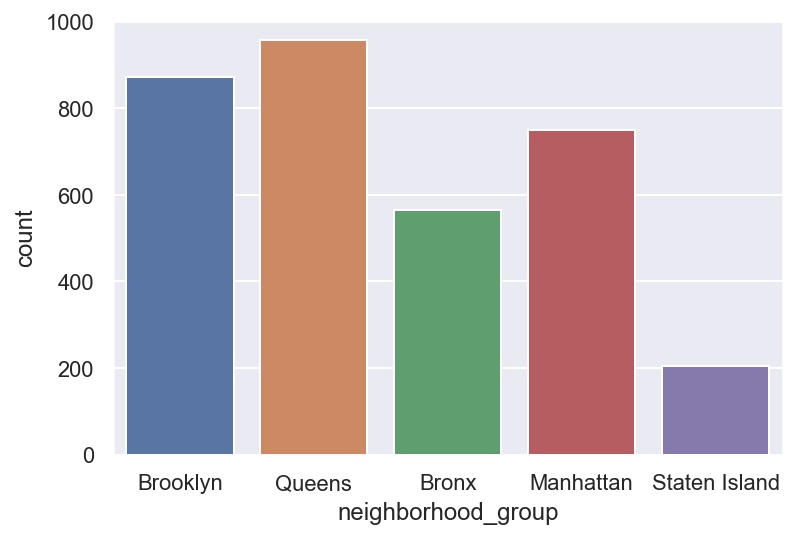

In [28]:
sns.set(style="darkgrid")
ax = sns.countplot(x="neighborhood_group", data=busstop)

In [29]:
# assign neighbourhood to point for subway